# Decision Tree

In [97]:
#Add libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report, roc_curve, roc_auc_score

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [98]:
#Get data
data = 'Data\stroke-data.csv'
df=pd.read_csv(data)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [99]:
#View summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [100]:
#Drop the unique ids
df = df.drop(['id'], axis=1)

In [101]:
#Find Categorical Variables
categorical = [var for var in df.columns if df[var].dtype == 'object']

print('There are {} categorical variables\n'.format(len(categorical)))
print('The categorical variables are:\n\n', categorical)

There are 5 categorical variables

The categorical variables are:

 ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [102]:
#view the categorical variables
df[categorical].head()

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked


In [103]:
# Check missing values in categorical variables
df[categorical].isnull().sum()

gender            0
ever_married      0
work_type         0
Residence_type    0
smoking_status    0
dtype: int64

In [104]:
# View frequency counts of values in categorical variables
for var in categorical:
    print(df[var].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
Yes    3353
No     1757
Name: ever_married, dtype: int64
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


In [105]:
# View frequency distribution of categorical variables
for var in categorical:
    print(df[var].value_counts() / np.float(len(df)))

Female    0.585910
Male      0.413894
Other     0.000196
Name: gender, dtype: float64
Yes    0.656164
No     0.343836
Name: ever_married, dtype: float64
Private          0.572407
Self-employed    0.160274
children         0.134442
Govt_job         0.128571
Never_worked     0.004305
Name: work_type, dtype: float64
Urban    0.508023
Rural    0.491977
Name: Residence_type, dtype: float64
never smoked       0.370254
Unknown            0.302153
formerly smoked    0.173190
smokes             0.154403
Name: smoking_status, dtype: float64


#### Explore smoking variables

In [106]:
# Check labels in smoke class
df.smoking_status.unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [107]:
#Replace 'Unknown' values in workclass variable with NaN
df['smoking_status'].replace('Unknown', np.NaN, inplace=True)
#Again check the frequency distribution of values in smoking status variable
df.smoking_status.value_counts()
df[categorical].isnull().sum()

gender               0
ever_married         0
work_type            0
Residence_type       0
smoking_status    1544
dtype: int64

In [108]:
# Check for cardinality in categorical variables
for var in categorical:
    print(var, 'contains', len(df[var].unique()), 'labels')

gender contains 3 labels
ever_married contains 2 labels
work_type contains 5 labels
Residence_type contains 2 labels
smoking_status contains 4 labels


#### Looking at Numerical Variables

In [109]:
# Find numerical variables
numerical = [var for var in df.columns if df[var].dtype != 'object']
print('There are {} numerical variables\n'.format(len(numerical)))
print('The numerical variables are :', numerical)

There are 6 numerical variables

The numerical variables are : ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']


In [110]:
#View the numerical variables
df[numerical].head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,67.0,0,1,228.69,36.6,1
1,61.0,0,0,202.21,NaN,1
2,80.0,0,1,105.92,32.5,1
3,49.0,0,0,171.23,34.4,1
4,79.0,1,0,174.12,24.0,1


In [111]:
#Check Missing values
df[numerical].isnull().sum()

age                    0
hypertension           0
heart_disease          0
avg_glucose_level      0
bmi                  201
stroke                 0
dtype: int64

### Feature Engineering

In [112]:
# Check data types
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [113]:
# Display categorical Variables
categorical = [col for col in df.columns if df[col].dtypes == 'object']
categorical

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [114]:
# Display numerical Variables
numerical = [col for col in df.columns if df[col].dtypes != 'object']
numerical

['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

In [115]:
# Print percentage of missing value in the categorical variable
df[categorical].isnull().mean()

gender            0.000000
ever_married      0.000000
work_type         0.000000
Residence_type    0.000000
smoking_status    0.302153
dtype: float64

In [116]:
# Print percentage of missing value in the numerical variable
df[numerical].isnull().mean()

age                  0.000000
hypertension         0.000000
heart_disease        0.000000
avg_glucose_level    0.000000
bmi                  0.039335
stroke               0.000000
dtype: float64

In [117]:
# Print categorical variables with missing data
for col in categorical:
    if df[col].isnull().mean() > 0:
        print(col, (df[col].isnull().mean()))

smoking_status 0.3021526418786693


In [118]:
# Print numerical variables with missing data
for col in numerical:
    if df[col].isnull().mean() > 0:
        print(col, (df[col].isnull().mean()))

bmi 0.03933463796477495


In [119]:
# Input missing variables with most frequent value
for df2 in [df]:
    df2['smoking_status'].fillna(df['smoking_status'].mode()[0], inplace=True)
    df2['bmi'].fillna(df['bmi'].mode()[0], inplace=True)

In [120]:
#Check missing values in categorical variables
df[categorical].isnull().sum()

gender            0
ever_married      0
work_type         0
Residence_type    0
smoking_status    0
dtype: int64

In [121]:
#Check missing values in numerical variables in X train
df[numerical].isnull().sum()

age                  0
hypertension         0
heart_disease        0
avg_glucose_level    0
bmi                  0
stroke               0
dtype: int64

In [122]:
# Check missing values in X_train
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Turn categorical to numerical

In [123]:
# Doing labelencoder
le_gender=LabelEncoder()
le_ever_married=LabelEncoder()
le_work_type=LabelEncoder()
le_Residence_type=LabelEncoder()
le_smoking_status=LabelEncoder()

#Change to data
df['gender_n']=le_gender.fit_transform(df['gender'])
df['ever_married_n']=le_ever_married.fit_transform(df['ever_married'])
df['work_type_n']=le_work_type.fit_transform(df['work_type'])
df['Residence_type_n']=le_Residence_type.fit_transform(df['Residence_type'])
df['smoking_status_n']=le_smoking_status.fit_transform(df['smoking_status'])
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,gender_n,ever_married_n,work_type_n,Residence_type_n,smoking_status_n
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,1,1,2,1,0
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.7,never smoked,1,0,1,3,0,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,1,1,2,0,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,0,1,2,1,2
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,0,1,3,0,1


In [124]:
df_n=df.drop(['gender','ever_married','work_type','Residence_type','smoking_status'],axis='columns')
df_n.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_n,ever_married_n,work_type_n,Residence_type_n,smoking_status_n
0,67.0,0,1,228.69,36.6,1,1,1,2,1,0
1,61.0,0,0,202.21,28.7,1,0,1,3,0,1
2,80.0,0,1,105.92,32.5,1,1,1,2,0,1
3,49.0,0,0,171.23,34.4,1,0,1,2,1,2
4,79.0,1,0,174.12,24.0,1,0,1,3,0,1


### Split Data

In [125]:
X = df_n.drop('stroke', axis='columns')
Y = df_n['stroke']

In [126]:
#Split data into separate training and test and test set
X_train, X_test, Y_train, Y_test=train_test_split(X,Y, test_size=0.3, random_state=0)

### Training Classifier

In [127]:
model=tree.DecisionTreeClassifier()

# Fit the model
model.fit(X_train, Y_train)

DecisionTreeClassifier()

### Predict the Results

In [128]:
Y_pred = model.predict(X_test)

Y_pred

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

### Check Accuracy Score

In [129]:
print('Model accuracy score: {0:0.4f}'.format(accuracy_score(Y_test, Y_pred)))

Y_pred_train = model.predict(X_train)
Y_pred_train

Model accuracy score: 0.9198


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [130]:
print('Training-set accuracy score: {0:0.4f}'.format(accuracy_score(Y_train, Y_pred_train)))

# Print the scores on training and test set
print('Training set score: {:.4f}'.format(model.score(X_train, Y_train)))
print('Test set score: {:.4f}'.format(model.score(X_test, Y_test)))

Training-set accuracy score: 1.0000
Training set score: 1.0000
Test set score: 0.9198


In [131]:
# Check class distribution in test set
null_info = Y_test.value_counts()
null_info

0    1457
1      76
Name: stroke, dtype: int64

In [132]:
# Check Null Accuracy Score
null_accuracy = null_info.iloc[0] / (null_info.iloc[0] + null_info.iloc[1])
print('Null accuracy score: {0:0.4f}'.format(null_accuracy))

Null accuracy score: 0.9504


In [133]:
# Print the Confusion Matrix and slice it into four pieces
cm = confusion_matrix(Y_test, Y_pred)

print('Confusion matrix\n\n', cm)

print('\nTrue Positives(TP) = ', cm[0, 0])

print('\nTrue Negatives(TN) = ', cm[1, 1])

print('\nFalse Positives(FP) = ', cm[0, 1])

print('\nFalse Negatives(FN) = ', cm[1, 0])

Confusion matrix

 [[1397   60]
 [  63   13]]

True Positives(TP) =  1397

True Negatives(TN) =  13

False Positives(FP) =  60

False Negatives(FN) =  63


<Axes: >

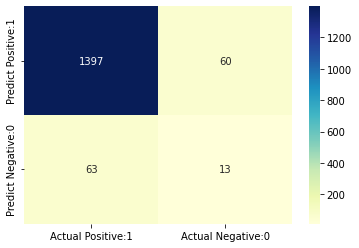

In [134]:
# Visualise confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                         index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [135]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1457
           1       0.18      0.17      0.17        76

    accuracy                           0.92      1533
   macro avg       0.57      0.56      0.57      1533
weighted avg       0.92      0.92      0.92      1533



In [136]:
# Print classification accuracy

TP = cm[0, 0]
TN = cm[1, 1]
FP = cm[0, 1]
FN = cm[1, 0]

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

Classification accuracy : 0.9198


In [137]:
# Print Classification Error

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))

Classification error : 0.0802


In [138]:
#Print Precision score
precision = TP / float(TP + FP)
print('Precision : {0:0.4f}'.format(precision))

Precision : 0.9588


In [139]:
#Print Recall
recall = TP / float(TP + FN)
print('Recall or Sensitivity : {0:0.4f}'.format(recall))

Recall or Sensitivity : 0.9568


In [140]:
#True positive Rate
TPR = TP / float(TP + FN)
print('True Positive Rate : {0:0.4f}'.format(TPR))

True Positive Rate : 0.9568


In [141]:
#False positive rate
FPR = FP / float(FP + TN)
print('False Positive Rate : {0:0.4f}'.format(FPR))

False Positive Rate : 0.8219


In [142]:
#Specificity
specificity = TN / (TN + FP)
print('Specificity : {0:0.4f}'.format(specificity))

Specificity : 0.1781


### Calculate Class Probabilities

In [143]:
# Print the first 10 predicted probabilities of two classes- 0 and 1

Y_pred_prob = model.predict_proba(X_test)[0:10]
Y_pred_prob

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [144]:
# Store the probabilities in dataframe
Y_pred_prob_df = pd.DataFrame(data=Y_pred_prob, columns=['Stroke', 'No Stroke'])
Y_pred_prob_df

,Stroke,No Stroke
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


In [145]:
# Print the first 10 predicted probabilities for class 1 - Probability of stroke
model.predict_proba(X_test)[0:10, 1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [146]:
# Store the predicted probabilities for class 1 - Probability of stroke
Y_pred1 = model.predict_proba(X_test)[:, 1]

Text(0, 0.5, 'Frequency')

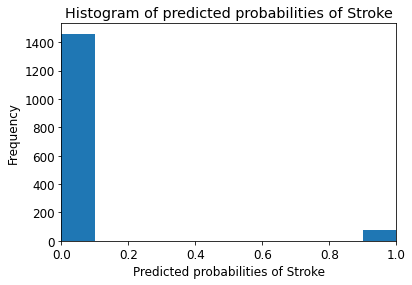

In [147]:
# Plot histogram of predicted probabilities

# adjust the font size
plt.rcParams['font.size'] = 12

# plot histogram with 10 bins
plt.hist(Y_pred1, bins=10)

# set the title of predicted probabilities
plt.title('Histogram of predicted probabilities of Stroke')

# set the x-axis limit
plt.xlim(0, 1)

# set the title
plt.xlabel('Predicted probabilities of Stroke')
plt.ylabel('Frequency')

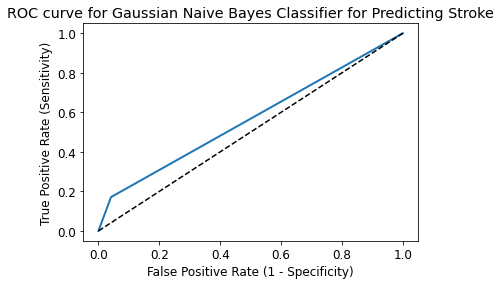

In [148]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_pred1)

plt.figure(figsize=(6, 4))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')

plt.rcParams['font.size'] = 12

plt.title('ROC curve for Gaussian Naive Bayes Classifier for Predicting Stroke')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

In [149]:
# Compute ROC AUC
ROC_AUC = roc_auc_score(Y_test, Y_pred1)

print('ROC AUC : {:.4f}'.format(ROC_AUC))
# Calculate cross-validated ROC AUC
Cross_validated_ROC_AUC = cross_val_score(model, X_train, Y_train, cv=5, scoring='roc_auc').mean()

print('Cross validated ROC AUC : {:.4f}'.format(Cross_validated_ROC_AUC))

ROC AUC : 0.5649
Cross validated ROC AUC : 0.5295


In [150]:
# Applying 10-Fold Cross Validation
scores = cross_val_score(model, X_train, Y_train, cv=10, scoring='accuracy')

print('Cross-validation scores:{}'.format(scores))

Cross-validation scores:[0.91061453 0.92178771 0.88547486 0.92178771 0.91340782 0.88547486
 0.89944134 0.91316527 0.91316527 0.93557423]


In [151]:
# Compute Average cross-validation score

print('Average cross-validation score: {:.4f}'.format(scores.mean()))

Average cross-validation score: 0.9100


### Plotting the Decision Tree

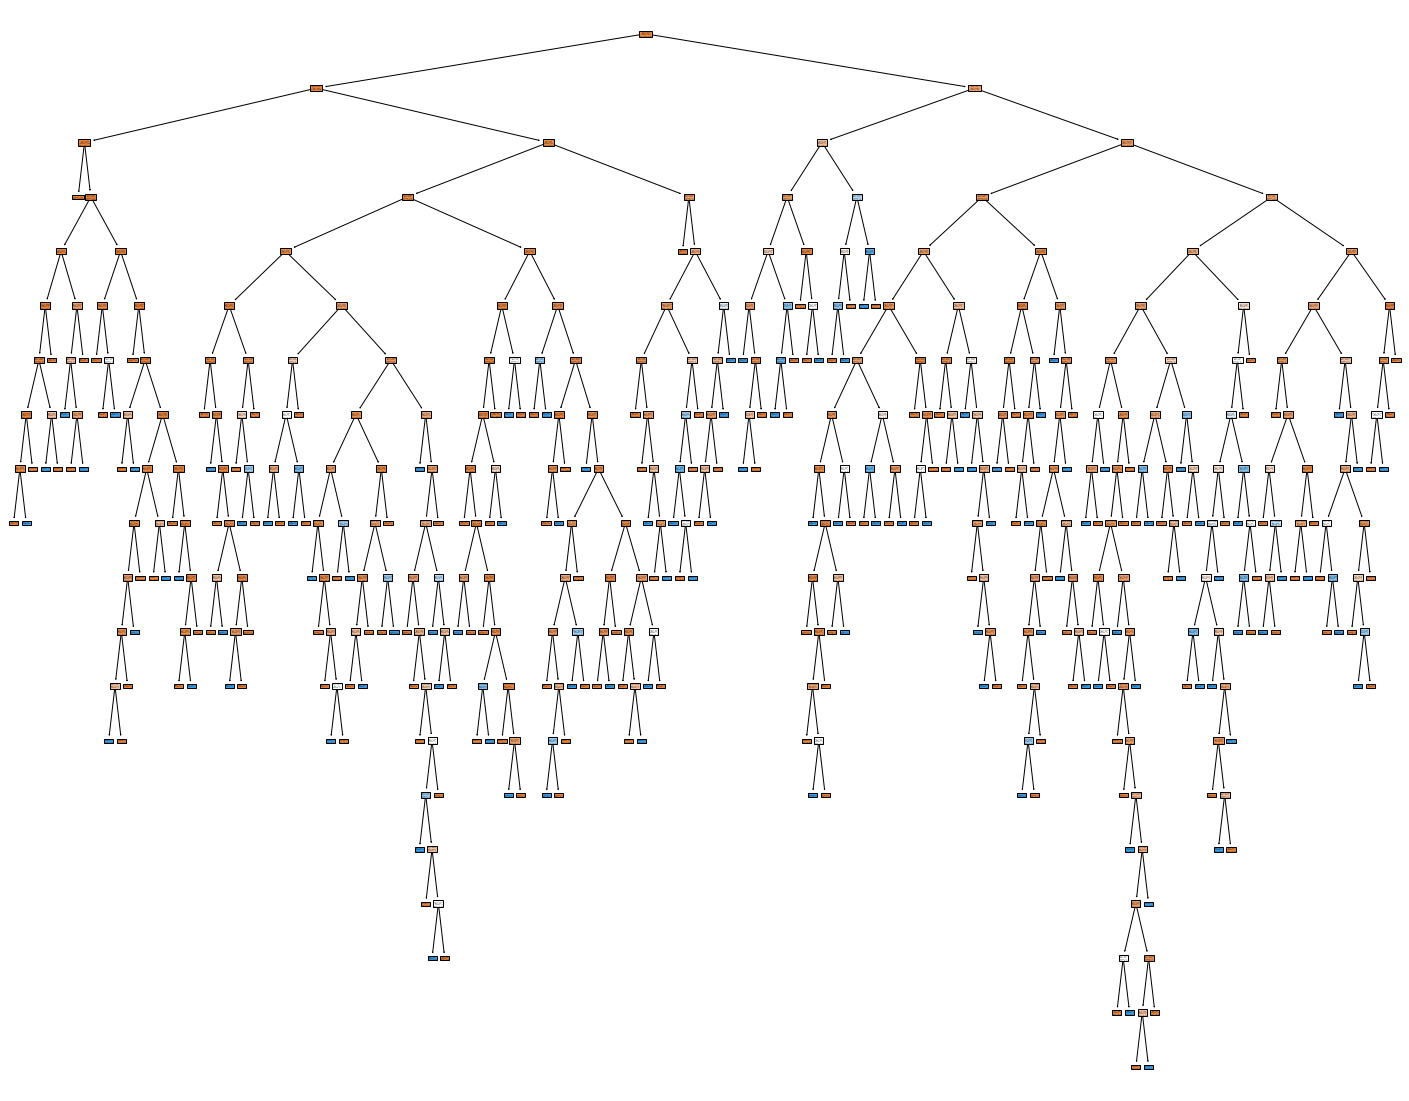

In [152]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model,filled=True)
fig.savefig("decision_tree.png")

### Split Data

In [ ]:
inputs =df.drop('stroke',axis='columns')
target = df['stroke']
inputs

In [ ]:
target

### Turn categorical to numerical

In [ ]:
# Doing labelencoder
le_gender=LabelEncoder()
le_ever_married=LabelEncoder()
le_work_type=LabelEncoder()
le_Residence_type=LabelEncoder()
le_smoking_status=LabelEncoder()

#Change to inputs
inputs['gender_n']=le_gender.fit_transform(inputs['gender'])
inputs['ever_married_n']=le_ever_married.fit_transform(inputs['ever_married'])
inputs['work_type_n']=le_work_type.fit_transform(inputs['work_type'])
inputs['Residence_type_n']=le_Residence_type.fit_transform(inputs['Residence_type'])
inputs['smoking_status_n']=le_smoking_status.fit_transform(inputs['smoking_status'])
inputs.head()

In [ ]:
inputs_n=inputs.drop(['gender','ever_married','work_type','Residence_type','smoking_status'],axis='columns')
inputs_n.head()

### Training Classifier

In [ ]:
model=tree.DecisionTreeClassifier()
model.fit(inputs_n, target)

In [ ]:
model.score(inputs_n,target)

In [ ]:
model.predict([[61.0,0,0,202.21,28.7,0,1,3,0,1]])